# Đọc dữ liệu
Đọc ảnh images được lấy từ ảnh vệ tinh, các ảnh được lấy mẫu hầu hết ở các tỉnh ngoại thành, và một vài ảnh ở khu vực đông dân cư (dữ liệu được lấy từ https://earth.google.com/web).

Em có sử dụng các ứng dụng để vẽ được polygon mái nhà như `labelme` (file json) sau đó đọc ảnh bằng cv2 lưu lại các mái nhà dưới dạng ảnh nhị phân bitmask.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import imageio
%matplotlib inline



# reading the data
project_path = "D:\\TTNT 2025\\"
images_path = os.path.join(project_path, "Data\\images_vn\\")
labels_path = os.path.join(project_path, "Data\\labels_vn\\")
images_list = os.listdir(images_path)
labels_list = os.listdir(labels_path)
images_dir_list = [images_path+i for i in images_list]
labels_dir_list = [labels_path+i for i in labels_list]


images = []
labels= []


for i in range(len(labels_dir_list)):
    img = imageio.imread(images_dir_list[i])
    bitMask = imageio.imread(labels_dir_list[i])
    bitMask = np.where(bitMask>0,1,0) # convert to binary mask
    images.append(img[:,:,:3]/255.) # remove the alpha channel
    labels.append(bitMask.reshape((256,256,1)))

    
    
images, labels = np.array(images), np.array(labels) 

print(images_dir_list)
print(labels_dir_list)

C:\Users\Thu Hien Le\AppData\Local\Temp\ipykernel_11120\1047479645.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(images_dir_list[i])
C:\Users\Thu Hien Le\AppData\Local\Temp\ipykernel_11120\1047479645.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  bitMask = imageio.imread(labels_dir_list[i])


['D:\\TTNT 2025\\Data\\images_vn\\01.png', 'D:\\TTNT 2025\\Data\\images_vn\\02.png', 'D:\\TTNT 2025\\Data\\images_vn\\03.png', 'D:\\TTNT 2025\\Data\\images_vn\\04.png', 'D:\\TTNT 2025\\Data\\images_vn\\05.png', 'D:\\TTNT 2025\\Data\\images_vn\\06.png', 'D:\\TTNT 2025\\Data\\images_vn\\07.png', 'D:\\TTNT 2025\\Data\\images_vn\\08.png', 'D:\\TTNT 2025\\Data\\images_vn\\09.png', 'D:\\TTNT 2025\\Data\\images_vn\\10.png', 'D:\\TTNT 2025\\Data\\images_vn\\11.png', 'D:\\TTNT 2025\\Data\\images_vn\\12.png', 'D:\\TTNT 2025\\Data\\images_vn\\13.png', 'D:\\TTNT 2025\\Data\\images_vn\\14.png', 'D:\\TTNT 2025\\Data\\images_vn\\15.png', 'D:\\TTNT 2025\\Data\\images_vn\\16.png', 'D:\\TTNT 2025\\Data\\images_vn\\17.png', 'D:\\TTNT 2025\\Data\\images_vn\\18.png', 'D:\\TTNT 2025\\Data\\images_vn\\19.png', 'D:\\TTNT 2025\\Data\\images_vn\\20.png', 'D:\\TTNT 2025\\Data\\images_vn\\21.png', 'D:\\TTNT 2025\\Data\\images_vn\\22.png', 'D:\\TTNT 2025\\Data\\images_vn\\23.png', 'D:\\TTNT 2025\\Data\\images_vn\\

Vẽ biểu đồ dữ liệu bất kỳ.

D:\TTNT 2025\Data\images_vn\18.png D:\TTNT 2025\Data\labels_vn\18.png
17


Text(0.5, 1.0, 'Segmentation')

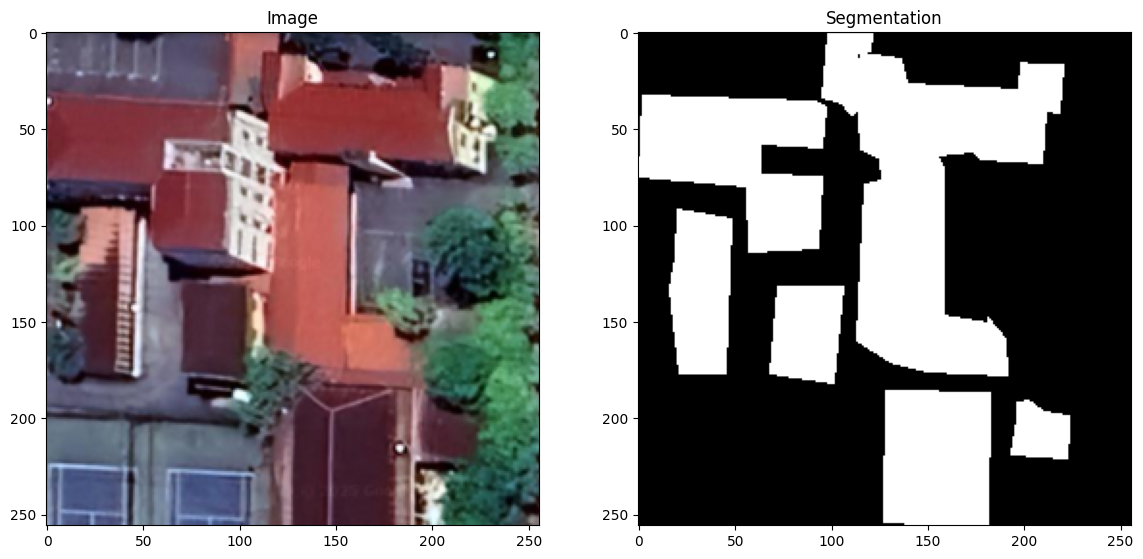

In [7]:
i = np.random.randint(0, len(images_dir_list))
img, lbl = images[i], labels[i]
lbl = lbl.reshape((256,256,1))

print(images_dir_list[i], labels_dir_list[i])
print(i)

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(lbl, cmap='gray')
arr[1].set_title('Segmentation')

# Segmentation-models

Để thực hiện chuyển việc học cho mô hình phân đoạn, ở đây em sử dụng mô hình "segmentation_models" có sẵn trên https://segmentation-models.readthedocs.io/en/latest/tutorial.html. Tất cả các quá trình tiền xử lý và chuyển giao học tập đều được thực hiện tự động.

In [8]:
from sklearn.model_selection import train_test_split
import random
import segmentation_models as sm
import keras

BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

# preprocess input to be consistent with the trained network 
images_pro = preprocess_input1(images)


# test-train split
X_train, X_test, y_train, y_test = train_test_split(images_pro, labels, test_size = 0.2, random_state = 101)
print(X_train.shape)
print(X_test.shape)

Segmentation Models: using `keras` framework.
(40, 256, 256, 3)
(10, 256, 256, 3)


# Data Augmentation

Mục đích: 

- Tạo ra các phiên bản biến đổi của ảnh/mask gốc để:

- Tăng kích thước tập dữ liệu ảo

- Giúp mô hình học được tính bất biến (invariance) với các biến đổi hình học

- Chống overfitting

Ở đây chúng ta sử dụng 1 hàm để đảm bảo việc từng cặp ảnh sau khi augument được đồng bộ

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
seed = 101

image_generate = ImageDataGenerator(
    rotation_range = 90,          # Xoay ngẫu nhiên 0-90 độ
    width_shift_range = 0.3,      # Dịch ngang 30% chiều rộng
    height_shift_range = 0.3,     # Dịch dọc 30% chiều cao
    shear_range = 0.5,            # Biến dạng trượt (shear)
    zoom_range = 0.3,             # Phóng to/thu nhỏ 30%
    horizontal_flip = True,       # Lật ngang
    vertical_flip = True,         # Lật dọc
    fill_mode = 'reflect'         # Cách điền pixel khi biến đổi
)

image_generate.fit(X_train, augment=True, seed=seed)

image_generator = image_generate.flow(X_train, seed=seed) # Tạo batch dữ liệu từ X_train

validate_img_generator = image_generate.flow(X_test, seed=seed) # Tạo batch dữ liệu từ X_test

label_generate = ImageDataGenerator(
    rotation_range = 90, 
    width_shift_range = 0.3, 
    height_shift_range = 0.3,
    shear_range = 0.5, 
    zoom_range = 0.3, 
    horizontal_flip = True,
    vertical_flip = True, 
    fill_mode = 'reflect',
    preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))

label_generate.fit(y_train, augment=True, seed=seed)

label_generator = label_generate.flow(y_train, seed=seed) # Tạo batch dữ liệu từ y_train

validate_lbl_generator = label_generate.flow(y_test, seed=seed) # Tạo batch dữ liệu từ y_test

def image_mask_generator(image_generator, label_generator):
    train_generator = zip(image_generator, label_generator) # Kết hợp 2 generator
    for (img, mask) in train_generator:
        yield (img, mask) # Trả về 1 tuple (img, mask) từ 2 generator

my_generator = image_mask_generator(image_generator, label_generator)
validation_data = image_mask_generator(validate_img_generator, validate_lbl_generator)

## Huấn luyện mô hình Segmentation sử dụng kiến trúc UNet với BACKBONE Resnet34

Đoạn code dưới đây định nghĩa và huấn luyện mô hình segmentation sử dụng kiến trúc U-Net với backbone là ResNet34 (được xác định trước đó qua biến BACKBONE)

Em sử dụng UNet là kiến trúc phổ biến cho bài toán segmentation, Backbone (resnet34): Mạng CNN làm encoder để trích xuất đặc trưng.

Hàm mất mát bce_jaccard_loss là kết hợp giữa Binary Cross-Entropy (BCE) và Jaccard Loss (IoU Loss):
$$\text{Loss} = \text{BCE} + (1 - \text{IoU})$$
Cho từng pixel, công thức BCE như sau:
$$
BCE = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \cdot \log(p_i) + (1 - y_i) \cdot \log(1 - p_i) \right]
$$

- \( y_i \): Giá trị thực của pixel (0 hoặc 1).  
- \( p_i \): Xác suất dự đoán pixel thuộc lớp 1 (trong khoảng \([0,1]\)).  
- \( N \): Tổng số pixel.  
Công thức tính chỉ số IoU đo độ chính xác vùng chồng lấn:
$$
IoU = \frac{\text{Predicted Mask} \cap \text{Ground Truth}}{\text{Predicted Mask} \cup \text{Ground Truth}}
$$

- **Giá trị IoU nằm trong khoảng [0, 1]:**
  - **0**: Dự đoán hoàn toàn sai (không có sự chồng lắp).
  - **1**: Dự đoán trùng khớp hoàn hảo với Ground Truth.


In [5]:
from tensorflow.keras.optimizers import Adam
sm.set_framework('tf.keras')

model = sm.Unet(
    BACKBONE,
    encoder_weights='imagenet'  # Sử dụng trọng số pretrained từ ImageNet
)
model.compile(
    optimizer='Adam',
    loss=sm.losses.bce_jaccard_loss,  # Kết hợp BCE và Jaccard Loss
    metrics=[sm.metrics.iou_score]    # Theo dõi IoU trong quá trình train
)

print(model.summary())

# Training the model
history = model.fit(            # Lưu giữ toàn bộ lịch sử huấn luyện
    my_generator,               # Generator cho tập train
    validation_data = validation_data,  # Generator cho tập validation
    steps_per_epoch = 50,        # Số batch mỗi epoch (tập train)
    validation_steps = 50,       # Số batch validation mỗi epoch
    epochs = 80                # Số epoch tối đa
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, None,      │      4,096 │ stage1_unit1_rel

 Total params: 24,456,154 (93.29 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

None
Epoch 1/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 252s 4s/step - iou_score: 0.3023 - loss: 1.1248 - val_iou_score: 0.2153 - val_loss: 9.5682
Epoch 2/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 224s 4s/step - iou_score: 0.6502 - loss: 0.5230 - val_iou_score: 0.0985 - val_loss: 1.4553
Epoch 3/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 226s 5s/step - iou_score: 0.7311 - loss: 0.3942 - val_iou_score: 0.0388 - val_loss: 2.9122
Epoch 4/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 230s 5s/step - iou_score: 0.7149 - loss: 0.4380 - val_iou_score: 0.1670 - val_loss: 1.4557
Epoch 5/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 229s 5s/step - iou_score: 0.7359 - loss: 0.3916 - val_iou_score: 0.0075 - val_loss: 2.1278
Epoch 6/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 232s 5s/step - iou_score: 0.7562 - loss: 0.3545 - val_iou_score: 0.0024 - val_loss: 2.3406
Epoch 7/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 230s 5s/step - iou_score: 0.7866 - loss: 0.3088 - val_iou_score: 0.1919 - val_loss: 2.0027
Epoch 8/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 231s 5s/step - iou_score: 0.8032 - loss: 0.2870 - val_

Những vấn đề hiện tại
- Thời gian/epoch quá lâu (15p/epoch) -> Tăng batch_size hoặc đảm bảo GPU
- Validation loss tăng -> Thử giảm learning rate (đang mặc định là 1e-3)
- Overfitting (IoU train cao nhưng val thấp) -> Thêm Regularizationv, augmentation mạnh hơn, Early Stopping


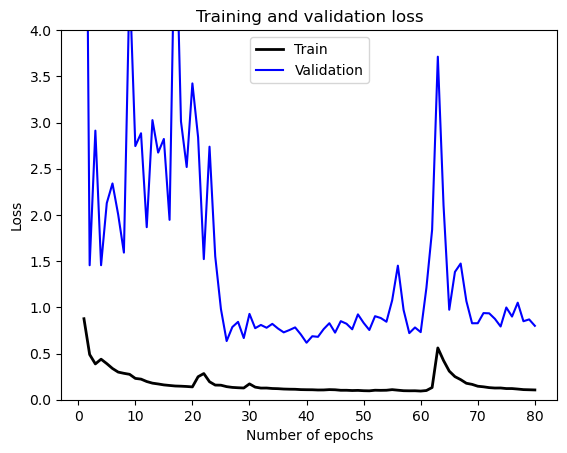

In [9]:
train_loss = history.history['loss']
validation_loss = history.history['val_loss']
number_epochs = range(1, len(train_loss) + 1)

plt.plot(number_epochs, train_loss, 'k', lw=2, label='Train')
plt.plot(number_epochs, validation_loss, 'b', label='Validation')
plt.title('Training and validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.ylim(0,4)
plt.legend()
plt.show()

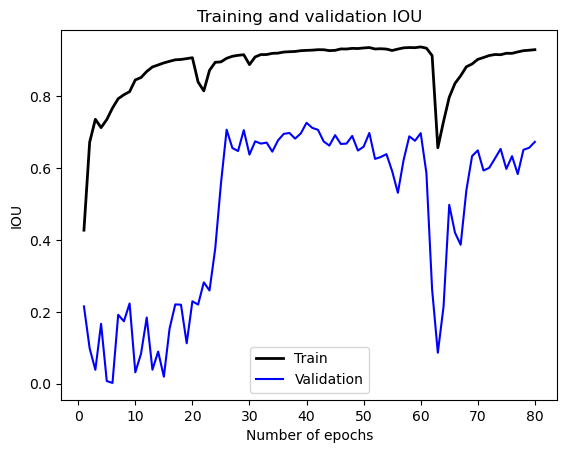

In [7]:
iou_score = history.history['iou_score']
validation_iou_score = history.history['val_iou_score']

plt.plot(number_epochs, iou_score, 'k', lw=2, label='Train')
plt.plot(number_epochs, validation_iou_score, 'b', label='Validation')
plt.title('Training and validation IOU')
plt.xlabel('Number of epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()